<a href="https://colab.research.google.com/github/DkMaria/Fake-News-Detection/blob/main/imbalanced_word2vec_12_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# verify GPU availability
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
# Download following if not downloaded in local machine
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from wordcloud import WordCloud
import imblearn
from collections import Counter

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

FALSE:                                                 headline  ... label
0                           Who Stripped Jessica Rabbit  ...     1
1            Translation of Turkish Airline Regulations  ...     1
2     The health care law a ""job killer""? The evid...  ...     1
3     FALSE: Trump Supporters Misspelled His Name wi...  ...     1
4                      Tom Daschle Pledge of Allegiance  ...     1
...                                                 ...  ...   ...
9995  Rauner's Chicago schools ""bailout"" claim roo...  ...     1
9996  Did President Trump Sign an Executive Order Na...  ...     1
9997                                One Pound of Mofeen  ...     1
9998  No, Trump didn't say illegal immigration has b...  ...     1
9999   Is This a Poster for a New ‚ÄòTwilight‚Äô Movie?  ...     1

[10000 rows x 5 columns]


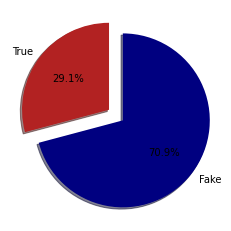

In [ ]:
# read csv files which contains all TRUE and all FALSE claims
true = pd.read_csv('/content/drive/MyDrive/true28.csv', delimiter=",")
df_true = pd.DataFrame(true, columns=['headline', 'text', 'keywords', 'ratingName'])
df_true['label'] = 0
# print('TRUE: ', df_true)
# print(len(df_true)) # 4113


false = pd.read_csv('/content/drive/MyDrive/false05.csv', delimiter=",", encoding='mac_roman')
df_false = pd.DataFrame(false, columns=['headline', 'text', 'keywords', 'ratingName'])
df_false['label'] = 1
print('FALSE: ', df_false)
# print(len(df_false)) #10000

data = pd.concat([df_true, df_false])
labels = data['label']
# print(data) # 14113
# print(data['label'].value_counts())
# 1: 10000
# 0: 4113

# check if the dataset is well balanced
label_size = [4113, 10000]
plt.pie(label_size, explode=[0.1, 0.1], colors=['firebrick', 'navy'], startangle=90, shadow=True,
        labels=['True', 'Fake'], autopct='%1.1f%%')
plt.show()

# shuffle the dataset
data = data.sample(frac=1)
# print(data.head(20))

In [ ]:
label = data['label']
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14113 entries, 9948 to 8773
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   headline    14113 non-null  object
 1   text        14113 non-null  object
 2   keywords    14113 non-null  object
 3   ratingName  14113 non-null  bool  
 4   label       14113 non-null  int64 
dtypes: bool(1), int64(1), object(3)
memory usage: 565.1+ KB


In [ ]:
# class count
true_count, false_count = data['label'].value_counts()
# Separate class
true = data[data['label'] == 0] #true claims
false = data[data['label'] == 1]# print the shape of the class #false claims
print('true 0:', true.shape)
print('false 1:', false.shape)

true 0: (4113, 5)
false 1: (10000, 5)


total class of 1 and 0: 1    4113
0    4113
Name: label, dtype: int64


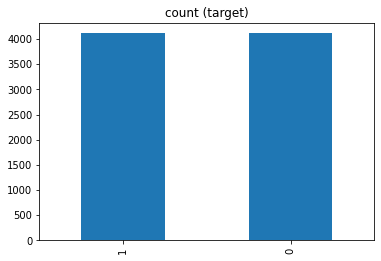

In [ ]:
'''Undersampling can be defined as removing some observations of the majority class. This is done until the majority and 
minority class is balanced out'''
false_under = false.sample(false_count)
#print(class_1_under)

data = pd.concat([false_under, true], axis=0)

print("total class of 1 and 0:",data['label'].value_counts())# plot the count after under-sampeling
data['label'].value_counts().plot(kind='bar', title='count (target)')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8226 entries, 4272 to 2957
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   headline    8226 non-null   object
 1   text        8226 non-null   object
 2   keywords    8226 non-null   object
 3   ratingName  8226 non-null   bool  
 4   label       8226 non-null   int64 
dtypes: bool(1), int64(1), object(3)
memory usage: 329.4+ KB


In [ ]:
target = data['label']

In [ ]:
y = data["text"].values
#Converting X to format acceptable by gensim, removing annd punctuation stopwords in the process
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in data["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

del data

In [ ]:
len(X)

8226

Word2Vec implementation
Word2Vec is one of the most popular technique to learn word embeddings using shallow neural network. It was developed by Tomas Mikolov in 2013 at Google.

Word embedding is the most popular representation of document vocabulary. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.


In [ ]:
#create and check our own Word2Vec model with gensim
#Dimension of vectors we are generating
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)

In [ ]:
#vocab size
len(w2v_model.wv.vocab)

14741

In [ ]:
#see a sample vector for random word, lets say health
w2v_model["health"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([-0.43839285, -0.4932175 ,  0.62703663, -0.18694556, -0.12791602,
       -0.22854312,  0.88346714, -0.33090428, -0.24860436, -0.8107663 ,
       -0.16570173, -0.38784474, -0.1603296 ,  0.04321596, -0.19505455,
        0.17643312, -0.30591583,  0.13433132, -0.19965394, -0.1524461 ,
        0.00283498,  0.33380973, -0.04668997,  0.35342625, -0.20005754,
        0.16666123,  0.48989415, -0.07883285,  0.00116632, -0.42620644,
        0.26523957, -0.21510766, -0.74575406, -0.4878328 ,  0.08907425,
        0.25364342, -0.517766  ,  0.11258429,  0.2191993 , -0.00412446,
        0.02265214,  0.18493427,  0.36787552, -0.5254123 ,  0.33849406,
       -0.29416364,  0.15347673,  0.00887579,  0.0106462 , -0.15461795,
        0.19077022, -0.26642987,  0.8731433 , -0.27987078,  0.37683734,
        0.24859947,  0.00602625,  0.14863281, -0.10103885, -0.12447929,
       -0.05437266,  0.52295667, -0.78380066, -0.11634915,  0.0544257 ,
       -0.15421343, -0.04986753, -0.01171815,  0.05283066, -0.31

In [ ]:
#Feeding US Presidents
w2v_model.wv.most_similar(positive=["trump","obama", "clinton"])

[('presidential', 0.998899519443512),
 ('president', 0.9988746643066406),
 ('said', 0.9988381266593933),
 ('former', 0.9988139271736145),
 ('says', 0.9987863898277283),
 ('bush', 0.9987636804580688),
 ('2018', 0.9986414909362793),
 ('äôs', 0.9985404014587402),
 ('campaign', 0.9984791278839111),
 ('would', 0.9984733462333679)]

In [ ]:
# Tokenizing Text -> Repsesenting each word by a number
# Mapping of orginal word to number is preserved in word_index property of tokenizer

#Tokenized applies basic processing like changing it yo lower case, explicitely setting that as False
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [ ]:
# lets check the first 10 words of first news
#every word has been represented with a number
X[0][:10]

[27, 1261, 314, 3426, 3427, 121, 1017, 837, 4137]

In [ ]:
#Lets check few word to numerical replesentation
#Mapping is preserved in dictionary -> word_index property of instance
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break  

says -> 1
president -> 2
obama -> 3
shows -> 4
trump -> 5
percent -> 6
state -> 7
äôs -> 8
one -> 9
photograph -> 10


We can pass numerical representation of words into neural network.

We can use Many-To-One (Sequence-To-Word) Model of RNN, as we have many words in news as input and one output ie Probability of being Real.

For Many-To-One model, lets use a fixed size input.

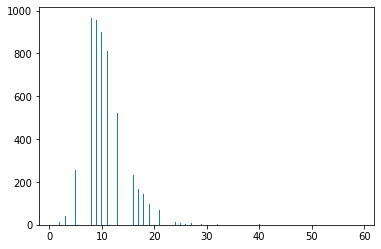

In [ ]:
# For determining size of input...

# Making histogram for no of words in news shows that most news article are under 20 words.
# Lets keep each news small and truncate all news to 20 while tokenizing
plt.hist([len(x) for x in X], bins=500)
plt.show()

In [ ]:
nos = np.array([len(x) for x in X])
len(nos[nos  < 20])

7977

In [ ]:
#Lets keep all news to 20, add padding to news with less than 20 words and truncating long ones
maxlen = 20 

#Making all news of size maxlen defined above
X = pad_sequences(X, maxlen=maxlen)

In [ ]:
#all news has 20 words (in numerical form now). If they had less words, they have been padded with 0
# 0 is not associated to any word, as mapping of words started from 1
# 0 will also be used later, if unknows word is encountered in test set
len(X[0])

20

In [ ]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [ ]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, word_index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [ ]:
print(embedding_vectors)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-4.64842290e-01 -5.15702963e-01  7.28903711e-01 ...  2.54575521e-01
  -3.86542797e-01 -2.62608737e-01]
 [-4.66518879e-01 -4.88476634e-01  7.16071427e-01 ...  2.56393939e-01
  -3.70755851e-01 -2.77469844e-01]
 ...
 [-1.15900446e-04 -4.69918782e-03  6.51163468e-03 ...  3.05494224e-03
  -8.92479555e-04 -5.02069574e-03]
 [-6.48108020e-04 -2.85998918e-03  9.39984166e-05 ... -9.85984574e-04
   8.12267710e-04 -3.00826808e-03]
 [-7.56854704e-03 -5.94694447e-03 -4.97201283e-04 ... -2.66045844e-03
   2.00112117e-04 -5.98262390e-03]]


In [ ]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 100)           1474200   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,591,577
Trainable params: 117,377
Non-trainable params: 1,474,200
_________________________________________________________________


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, target, test_size =0.20, random_state=42)
train_X, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size =0.10, random_state=42)
print('Size training set: ',len(x_train))
print('Size validation set: ', len(X_val))
print('Size test set: ', len(x_test))

Size training set:  6580
Size validation set:  658
Size test set:  1646


In [ ]:
history = model.fit(train_X, y_train, epochs=10,validation_data=(X_val, y_val))

Epoch 1/10
186/186 [==============================] - 10s 12ms/step - loss: 0.6934 - acc: 0.5133 - val_loss: 0.7035 - val_acc: 0.5030
Epoch 2/10
186/186 [==============================] - 2s 10ms/step - loss: 0.6924 - acc: 0.5108 - val_loss: 0.6970 - val_acc: 0.5061
Epoch 3/10
186/186 [==============================] - 2s 10ms/step - loss: 0.6906 - acc: 0.5297 - val_loss: 0.6960 - val_acc: 0.4970
Epoch 4/10
186/186 [==============================] - 2s 9ms/step - loss: 0.6898 - acc: 0.5387 - val_loss: 0.6995 - val_acc: 0.5061
Epoch 5/10
186/186 [==============================] - 2s 10ms/step - loss: 0.6890 - acc: 0.5361 - val_loss: 0.6963 - val_acc: 0.4924
Epoch 6/10
186/186 [==============================] - 2s 9ms/step - loss: 0.6879 - acc: 0.5385 - val_loss: 0.6991 - val_acc: 0.4954
Epoch 7/10
186/186 [==============================] - 2s 10ms/step - loss: 0.6872 - acc: 0.5404 - val_loss: 0.6970 - val_acc: 0.4954
Epoch 8/10
186/186 [==============================] - 2s 9ms/step - lo

In [ ]:
type(history)

keras.callbacks.History

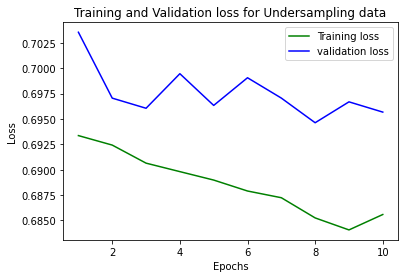

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,11)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for Undersampling data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

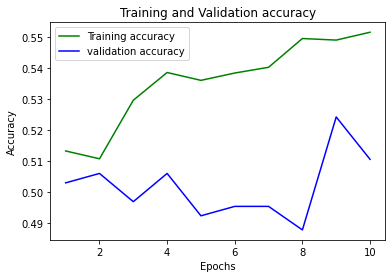

In [ ]:
loss_train = history.history['acc']
loss_val = history.history['val_acc']
epochs = range(1,11)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy for Undersampling data')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#Prediction is in probability of news being true, so converting into classes
# Class 1 (Fake) if predicted prob < 0.5, else class 0 (Real)
y_pred = (model.predict(x_test) >= 0.5).astype("int")
accuracy_score(y_test, y_pred)
target_names = ['real_news', 'fake_news']
print(classification_report(y_test, y_pred, target_names = target_names))

              precision    recall  f1-score   support

   real_news       0.54      0.66      0.59       816
   fake_news       0.57      0.44      0.50       830

    accuracy                           0.55      1646
   macro avg       0.55      0.55      0.54      1646
weighted avg       0.55      0.55      0.54      1646



   real_news       0.54      0.66      0.59       816
['real_news', '0.54', '0.66', '0.59', '816']
[0.54, 0.66, 0.59]
   fake_news       0.57      0.44      0.50       830
['fake_news', '0.57', '0.44', '0.50', '830']
[0.57, 0.44, 0.5]


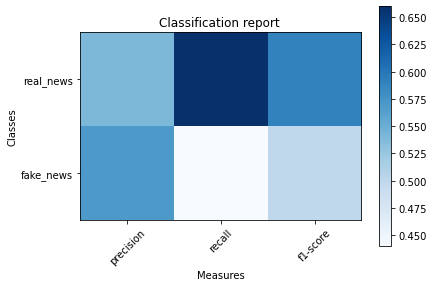

In [ ]:
import numpy as np

def plot_classification_report(cr, title='Classification report ', with_avg_total=False, cmap=plt.cm.Blues):

    lines = cr.split('\n')

    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 5)]:
        print(line)
        t = line.split()
        print(t)
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        print(v)
        plotMat.append(v)

    if with_avg_total:
        aveTotal = lines[len(lines) - 1].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)


    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')


ClassificationReport = classification_report(y_test, y_pred, target_names = target_names)
plot_classification_report(ClassificationReport)